In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

from brevitas.export import export_onnx_qcdq

import torchmetrics

import cv2

import config
import dataset_dfire
import datasets
import models_FINN as models
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = config.LOGS_FOLDER

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.\n' +  
            '\tOne Head.\n' +
            '\tAdding best mean F1 save.\n' +
            '\t256 Normalization.\n' +
            '\tWeighted for Precision.\n' +
            '\tModules.\n'+ 
            '\tLosses and Metrics Loggers.\n' +
            '\tBrevitas with All Layers defined in the Model, but Dropout and Flatten.\n' +
            '\tPer Tensor Float.\n' +
            '\tFASDD Val added.\n' +
            f'\tWeights bit width = {config.WEIGHTS_BIT_WIDTH}.\n' +
            f'\tBig Layers Weights bit width = {config.BIG_LAYERS_WEIGHTS_BIT_WIDTH}.\n' +
            f'\tActivations bit width = {config.ACTIVATIONS_BIT_WIDTH}.\n' +
            f'\tBias bit width = {config.BIAS_BIT_WIDTH}.\n' +
            f'\t{config.EPOCHS} epochs.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset_dfire.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

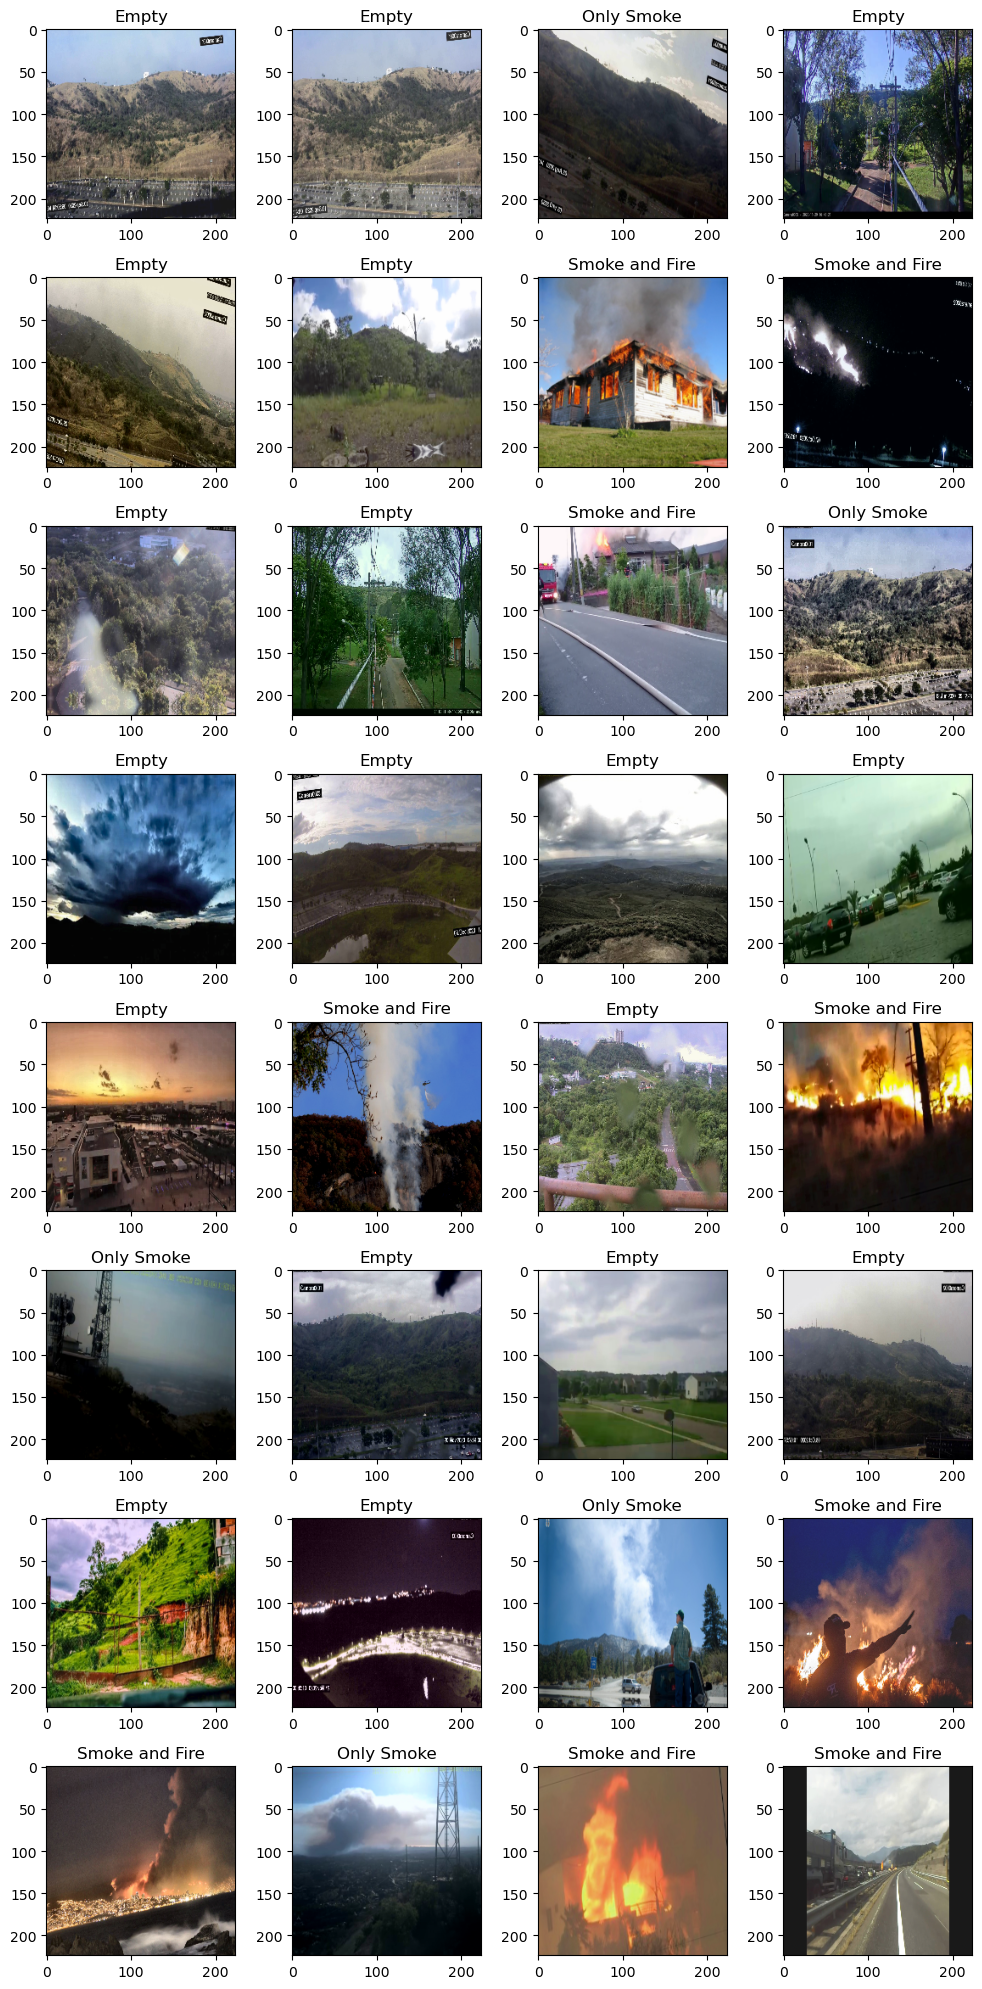

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_loader = datasets.get_train_loader()
val_loader = datasets.get_val_loader()


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 454
DFire only smoke images: 275
DFire only fire images: 59
DFire smoke and fire images: 212

Train DFire dataset len: 1000

TRAIN FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 464
FASDD only smoke images: 193
FASDD only fire images: 10
FASDD smoke and fire images: 333

Train FASDD UAV dataset len: 1000

VAL FASDD UAV dataset
FASDD Removed wrong images: 0
FASDD empty images: 471
FASDD only smoke images: 201
FASDD only fire images: 10
FASDD smoke and fire images: 318

Val FASDD UAV dataset len: 1000

TRAIN FASDD CV dataset
FASDD Removed wrong images: 0
FASDD empty images: 402
FASDD only smoke images: 257
FASDD only fire images: 147
FASDD smoke and fire images: 194

Train FASDD CV dataset len: 1000

Val FASDD CV dataset
FASDD Removed wrong images: 0
FASDD empty images: 386
FASDD only smoke images: 270
FASDD only fire images: 131
FASDD smoke and fire images: 213

Val FASDD CV dataset len: 1000

Co

# Models Setup

In [8]:
if config.MODEL == "BED":
    
    print("Using BED Classifier")
    logger.info("\nUsing BED Classifier")
    fp32_model = models.FUSED_BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
    

    print("Using Per Tensor Float without BN")
    logger.info("Using Per Tensor Float without BN")
    quant_model = models.QUANT_PerTensorFloat_NoBN_BED_CLASSIFIER(
            weight_bw = config.WEIGHTS_BIT_WIDTH,
            big_layers_weight_bw = config.BIG_LAYERS_WEIGHTS_BIT_WIDTH,
            act_bw = config.ACTIVATIONS_BIT_WIDTH,
            bias_bw = config.BIAS_BIT_WIDTH,
            num_classes=config.N_CLASSES).to(config.DEVICE)

else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

optimizer = optim.Adam(quant_model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in quant_model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(quant_model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Using Per Tensor Float without BN

Trainable parameters = 92800
Total parameters = 92800



### Check Model Shape

In [9]:
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = quant_model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{quant_model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{quant_model}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-9.0949e-13,  4.9826e-06],
        [-1.2457e-06,  4.3598e-06],
        [-1.2457e-06,  4.3598e-06],
        [-1.2457e-06,  4.3598e-06]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
QUANT_PerTensorFloat_NoBN_BED_CLASSIFIER(
  (model): Sequential(
    (input0): QuantIdentity(
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (act_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (fused_activation_quant_proxy): FusedActivationQuantProxy(
          (activation_impl): Identity()
          (tensor_quant): RescalingIntQuant(
            (int_quant): IntQuant(
              (float_to_int_impl): RoundSte()
              (tensor_clamp_impl): TensorClamp()
              (delay_wrapper): DelayWrapper(
                (delay_impl): _NoDelay()
              )
            )
            (scaling_impl): ParameterFromRuntimeStatsScaling(
              (stats_inp

# Load Pretrained or Initialize Weights

In [10]:
fp32_optimizer = optim.Adam(
    fp32_model.parameters(), 
    lr=config.LEARNING_RATE, 
    weight_decay=config.WEIGHT_DECAY)

fp32_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    fp32_optimizer, 
    mode='min',
    factor=config.FACTOR, 
    patience=config.PATIENCE, 
    threshold=config.THRES, 
    threshold_mode='abs',
    min_lr=config.MIN_LR)

if config.LOAD_MODEL == False:
    if config.MODEL == "BED":
        fp32_model.__initialize_weights__()
        print("Initializing Weights")
        logger.info("Initializing Weights")
else:
    epochs_trained = utils.load_checkpoint(config.LOAD_MODEL_FILE, fp32_model, fp32_optimizer, fp32_scheduler, config.DEVICE)
    logger.info(f"Loading Model. Trained during {epochs_trained} epochs")

Loading Model. Trained during 87 epochs


# Torchinfo: model summary

### Quant Model

In [11]:
quant_model.eval()
print(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Quant Model Summary")
logger.info(summary(quant_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                                                 Output Shape              Param #
QUANT_PerTensorFloat_NoBN_BED_CLASSIFIER                               [1, 2]                    --
├─Sequential: 1-1                                                      [1, 2]                    --
│    └─QuantIdentity: 2-1                                              [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                             [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                             [1, 3, 224, 224]          1
│    └─QuantReLU: 2-53                                                 --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-99                            --                        (recursive)
│    └─QuantIdentity: 2-3                                              --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-4                           

### FP32 Model

In [12]:
fp32_model.eval() # Do it before using the model for inference
print(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))
logger.info("Original FP32 Model Summary")
logger.info(summary(fp32_model, input_size=(1, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
FUSED_BED_CLASSIFIER                     [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Dropout2d: 2-3                    [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-4                    [1, 32, 112, 112]         --
│    └─Conv2d: 2-5                       [1, 16, 112, 112]         4,624
│    └─ReLU: 2-6                         [1, 16, 112, 112]         --
│    └─Dropout2d: 2-7                    [1, 16, 112, 112]         --
│    └─MaxPool2d: 2-8                    [1, 16, 56, 56]           --
│    └─Conv2d: 2-9                       [1, 16, 56, 56]           272
│    └─ReLU: 2-10                        [1, 16, 56, 56]           --
│    └─Conv2d: 2-11                      [1, 32, 56, 56]           4,640
│    └─

# Load Pretrained Weights from FP32 Model to Quant Model

In [13]:
# # Try to load fp32 weights to quant_model
from brevitas import config as brevitas_config

brevitas_config.IGNORE_MISSING_KEYS = True

### Load all Pretrained Weights

In [14]:
for fp32_name, fp32_mod in fp32_model.named_modules():
    for quant_name, quant_mod in  quant_model.named_modules():
        if fp32_name == quant_name:
            print(f'fp32 model name: {fp32_name} - quant model name: {quant_name}')
            if isinstance(fp32_mod, nn.Conv2d):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Conv2d layer fp32 {fp32_name} into quant {quant_name}')
            elif isinstance(fp32_mod, nn.Linear):
                if fp32_name == quant_name:
                    quant_mod.load_state_dict(fp32_mod.state_dict())
                    print(f'\t****** Loading weights of Linear layer fp32 {fp32_name} into quant {quant_name}')
            else:
                print(f'\t______ Ignore weights or params of layer fp32 {fp32_name} and quant {quant_name}')

fp32 model name:  - quant model name: 
	______ Ignore weights or params of layer fp32  and quant 
fp32 model name: model - quant model name: model
	______ Ignore weights or params of layer fp32 model and quant model
fp32 model name: model.conv1 - quant model name: model.conv1
	****** Loading weights of Conv2d layer fp32 model.conv1 into quant model.conv1
fp32 model name: model.relu1 - quant model name: model.relu1
	______ Ignore weights or params of layer fp32 model.relu1 and quant model.relu1
fp32 model name: model.maxpool2 - quant model name: model.maxpool2
	______ Ignore weights or params of layer fp32 model.maxpool2 and quant model.maxpool2
fp32 model name: model.conv2 - quant model name: model.conv2
	****** Loading weights of Conv2d layer fp32 model.conv2 into quant model.conv2
fp32 model name: model.relu2 - quant model name: model.relu2
	______ Ignore weights or params of layer fp32 model.relu2 and quant model.relu2
fp32 model name: model.maxpool3 - quant model name: model.maxpoo

# Loss Function

In [15]:
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'\nLoss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Loss Function: BCE
Smoke Precision Weight: 0.8


# Print and Log Config Values

In [16]:
''' ============================
    Print Config Values
============================ '''
print(f'\nDevice: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'\nDevice: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Scheduler factor: {config.FACTOR}')
logger.info(f'Scheduler patience: {config.PATIENCE}')
logger.info(f'Scheduler threshold: {config.THRES}')
logger.info(f'Scheduler min learning rate: {config.MIN_LR}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


Device: cuda
Learning Rate: 0.0001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)


# Loss and Metrics Loggers and Plotters

In [17]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()
lr_logger = utils.LogLR(log_path=config.PLOTS_FOLDER)

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [18]:
def train_loop(model, start_epoch=0):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')
    
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])
    best_mean_f1 = 0.

    #start_epoch = 0
    epochs_plot = []
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        current_lr = train_epoch.get_lr(optimizer=optimizer)
        logger.info(f'Learning Rate = {current_lr}\n')
        lr_logger.log_lr(current_lr)
                
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        lr_logger.plot_lr(epochs_plot)
        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__5epoch.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"Saving model with new best validation loss: {best_valid_loss:.3f}")
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + 'best_loss'  + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"Saving model with new best smoke precision: {best_smoke_precision:.3f}")
            save_precision_name = f'best_smoke__precision={np.round(best_smoke_precision, decimals=4)}__epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_precision_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name)  
            
        # Save model if precision > 0.9 and recall > 0.9
        if ( val_metrics['Precision'][0] > 0.9 ) and ( val_metrics['Recall'][0] > 0.9 ) :
            print("\nSaving model with precision > 0.9 and recall > 0.9")
            logger.info("Saving model with precision > 0.9 and recall > 0.9")
            save_pre_name = f'smoke__precision={np.round(val_metrics["Precision"][0], decimals=4)}__' 
            save_rec_name = f'recall={np.round(val_metrics["Recall"][0], decimals=4)}__'
            save_pre_rec_name = save_pre_name + save_rec_name + f'epoch={epoch}'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_pre_rec_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 

        # Save model if best mean F1 increases
        val_f1_mean = (val_metrics['F1'][0] + val_metrics['F1'][1]) / 2
        if (val_f1_mean > best_mean_f1) :
            best_mean_f1 = val_f1_mean
            print(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            logger.info(f'Saving model with best Mean F1: {best_mean_f1:.4f}')
            save_f1_name = 'best_mean_F1'
            save_name = config.WEIGHTS_FOLDER + config.MODEL + '_classifier__' + save_f1_name + '.pt'
            utils.save_checkpoint(epoch, model, optimizer, scheduler, save_name) 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), config.WEIGHTS_FOLDER + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    
    print("Starting script\n")
    logger.info("Starting script\n")

    qnn_model = train_loop(model=quant_model)

Starting script


***Start Training: 14:42:42


=== EPOCH 0/1 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [01:12<00:00,  1.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
188.902     |127.652     |61.250      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.820      |37.732      |37.087      
SMOKE -> Precision: 0.738 - Recall: 0.463 - Accuracy: 0.665 - F1: 0.569
FIRE -> Precision: 0.891 - Recall: 0.500 - Accuracy: 0.829 - F1: 0.640

Saving model with new best validation loss: 74.820
Saving model with best Mean F1: 0.6049

=== EPOCH 1/1 ===
Learning Rate = 0.0001



Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [01:12<00:00,  1.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
77.492      |41.862      |35.630      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  8.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.569      |33.333      |20.236      
SMOKE -> Precision: 0.804 - Recall: 0.497 - Accuracy: 0.702 - F1: 0.614
FIRE -> Precision: 0.849 - Recall: 0.753 - Accuracy: 0.884 - F1: 0.798

Saving model with new best validation loss: 53.569
Saving model with best Mean F1: 0.7063

***Script finished: 14:45:21

Time elapsed: 0:02:38.717825


# Export to ONNX

In [20]:
qnn_model.eval()
print("Model to eval")

Model to eval


In [21]:
#qnn_model.eval()
# export_onnx_qcdq(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qcdq.onnx')

### CPU export

In [22]:
# qnn_model.to('cpu')
# export_onnx_qcdq(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to('cpu'), 
#     export_path=config.RUN_FOLDER+'pretrained_qcdq_cpu.onnx')

# Load Checkpoint

In [36]:
qnn_model.to('cpu')

weights_folder = './experiments_fuseBN_256_fasdd/test_v41_FINN__PerTensorFloat_SignedIdentity_1000_imgs/weights/'
weights_file = weights_folder + 'BED_classifier__best_mean_F1.pt'

utils.load_checkpoint(
    model_path=weights_file,
    model=qnn_model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=config.DEVICE)

Loading Model. Trained during 1 epochs


1

## Eval Checkpoint

In [37]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = config.N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to('cpu')
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = config.N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to('cpu')
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = config.N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to('cpu')
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = config.N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to('cpu')

f1_metric_mean = torchmetrics.classification.MultilabelF1Score(num_labels = config.N_CLASSES, 
                                                               threshold = 0.5, 
                                                               average = 'macro').to('cpu')

In [38]:
def eval_metrics(loader, model, device='cpu'):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
    
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall_metric.update(yhat, y)
        accuracy_metric.update(yhat, y)
        f1_metric.update(yhat, y)
   
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()

    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    return {
        'Accuracy': [accuracy[0].item(), accuracy[1].item()],
        'Precision': [precision[0].item(), precision[1].item()],
        'Recall': [recall[0].item(), recall[1].item()],
        'F1': [f1[0].item(), f1[1].item()] 
        }

In [39]:
with torch.no_grad():
    val_metrics = eval_metrics(
        loader=val_loader, 
        model=qnn_model,                         
        device='cpu')

Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [01:43<00:00,  2.26s/it]

SMOKE -> Precision: 0.808 - Recall: 0.494 - Accuracy: 0.702 - F1: 0.613
FIRE -> Precision: 0.861 - Recall: 0.761 - Accuracy: 0.890 - F1: 0.808


In [40]:
print(val_metrics)
print(f'Mean F1: {(val_metrics["F1"][0]+val_metrics["F1"][1])/2}')

{'Accuracy': [0.7024456262588501, 0.8899456262588501], 'Precision': [0.8079161643981934, 0.8611111044883728], 'Recall': [0.4939501881599426, 0.7611607313156128], 'F1': [0.6130741834640503, 0.8080568909645081]}
Mean F1: 0.7105655372142792


## Export Best Mean F1 to ONNX

In [28]:
# qnn_model.to('cpu')
# export_onnx_qcdq(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to('cpu'), 
#     export_path=config.RUN_FOLDER+'BED__no_comp__best_mean_f1__cpu.onnx')

# Another ONNX Export option

In [41]:
from brevitas.export import export_qonnx
# from brevitas.export import export_onnx_qop

In [30]:
# export_onnx_qop(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).to(config.DEVICE), 
#     export_path=config.RUN_FOLDER+'pretrained_qop.onnx')

In [42]:
qonnx_model = export_qonnx(
    qnn_model, 
    torch.randn(1, 3, config.IMG_H, config.IMG_W).cpu(), 
    export_path=config.RUN_FOLDER+'pretrained_qonnx.onnx')

In [43]:
domains = qonnx_model.opset_import

In [44]:
for domain in domains:
    print(domain)

domain: ""
version: 17

domain: "onnx.brevitas"
version: 1



In [34]:
export_qonnx??

Signature:
export_qonnx(
    module: torch.nn.modules.module.Module,
    args: Union[torch.Tensor, brevitas.quant_tensor.QuantTensor, Tuple, NoneType] = None,
    export_path: Optional[str] = None,
    input_shape: Optional[Tuple[int, ...]] = None,
    input_t: Union[torch.Tensor, brevitas.quant_tensor.QuantTensor, NoneType] = None,
    disable_warnings=True,
    **onnx_export_kwargs,
)
Docstring: <no docstring>
Source:   
    @classmethod
    def export(
            cls,
            module: Module,
            args: Optional[Union[Tensor, QuantTensor, Tuple]] = None,
            export_path: Optional[str] = None,
            input_shape: Optional[Tuple[int, ...]] = None,  # legacy syntax, alternative to args
            input_t: Optional[Union[Tensor,
                                    QuantTensor]] = None,  # legacy syntax, alternative to args
            disable_warnings=True,
            **onnx_export_kwargs):
        return cls.export_onnx(
            module, args, export_path, 

In [35]:
# new_qonnx_model = export_qonnx(
#     qnn_model, 
#     torch.randn(1, 3, config.IMG_H, config.IMG_W).cpu(), 
#     export_path=config.RUN_FOLDER+'pretrained_qonnx_opset9.onnx',
#     target_opset={"":9})